# Anomlay Detection Web Analytics

Summary
-------
This notebook utilies the given query to search for anomalies in data stored in Redshift.
Currently two methods are supported:
- IsolationForest with shingle data (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
- Deviation of standard deviation from moving average.

Steps
-------
- load_data:  Loading data from Redshift.
- model build: Train the model on existing data. Unsupervised learning.
- predict: Estimate anomalies for the given dataset.

## Shingle
Expand a given vector of data to a matrix of consecuting points from the dataset.
- data : numpy array. A bucket to accumulate the data.
- single_size : int. Size of a bucket to accumulate the data. Default is one. In order to handle "rush hours" it can be tuned (e.g. 12).

However, the shingle algorithm helps in detecting when, for example, data breaks periodicity or uncharacteristically changes global behavior.

Depending on the kind of data you have there are several ways to improve algorithm performance. One method, for example, is to use an appropriate training set. If you know that a particular set of data is characteristic of "normal" behavior then training on said set of data will more accurately characterize "abnormal" data.

Another improvement is make use of a windowing technique called "shingling". This is especially useful when working with periodic data with known period, such as our dataset (site browsing). The idea is to treat a period of $P$ datapoints as a single datapoint of feature length $P$ and then run the RCF algorithm on these feature vectors. That is, if our original data consists of points $x_1, x_2, \ldots, x_N \in \mathbb{R}$ then we perform the transformation,

```
data = [[x_1],            shingled_data = [[x_1, x_2, ..., x_{P}],
        [x_2],    --->                     [x_2, x_3, ..., x_{P+1}],
        ...                                ...
        [x_N]]                             [x_{N-P}, ..., x_{N}]]

```

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.ensemble import IsolationForest
import psycopg2
import time


def shingle(data, shingle_size = 1):
    num_data = len(data)
    shingled_data = np.zeros((num_data-shingle_size, shingle_size))

    for n in range(num_data - shingle_size):
        shingled_data[n] = data[n:(n+shingle_size)]
    return shingled_data

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


## Load Data From Redshift - Sessions Per Hour

In [2]:
#Read Redshift credentials
import boto3
import base64
from botocore.exceptions import ClientError
import ast

def get_secret():

    secret_name = "GBRedshiftSecret"
    region_name = "us-east-2"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    # In this sample we only handle the specific exceptions for the 'GetSecretValue' API.
    # See https://docs.aws.amazon.com/secretsmanager/latest/apireference/API_GetSecretValue.html
    # We rethrow the exception by default.

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        if e.response['Error']['Code'] == 'DecryptionFailureException':
            # Secrets Manager can't decrypt the protected secret text using the provided KMS key.
            # Deal with the exception here, and/or rethrow at your discretion.
            raise e
        elif e.response['Error']['Code'] == 'InternalServiceErrorException':
            # An error occurred on the server side.
            # Deal with the exception here, and/or rethrow at your discretion.
            raise e
        elif e.response['Error']['Code'] == 'InvalidParameterException':
            # You provided an invalid value for a parameter.
            # Deal with the exception here, and/or rethrow at your discretion.
            raise e
        elif e.response['Error']['Code'] == 'InvalidRequestException':
            # You provided a parameter value that is not valid for the current state of the resource.
            # Deal with the exception here, and/or rethrow at your discretion.
            raise e
        elif e.response['Error']['Code'] == 'ResourceNotFoundException':
            # We can't find the resource that you asked for.
            # Deal with the exception here, and/or rethrow at your discretion.
            raise e
    else:
          # Decrypts secret using the associated KMS CMK.
        # Depending on whether the secret is a string or binary, one of these fields will be populated.
        if 'SecretString' in get_secret_value_response:
            secret = get_secret_value_response['SecretString']
            return(secret)
        else:
            decoded_binary_secret = base64.b64decode(get_secret_value_response['SecretBinary'])
            return(decode_binary_secret)

secret = get_secret()
USER = ast.literal_eval(secret)['username']
PASSWORD = ast.literal_eval(secret)['password']
HOST = ast.literal_eval(secret)['host']

In [3]:
import time

url_string = f"dbname='prod' port=5439 user='{USER}' password='{PASSWORD}' host='{HOST}'"
con = psycopg2.connect(url_string)
print(time.ctime(), "Redshift connection Successful!")
cur = con.cursor()

#In this query we need to configure the number of days to look back for anomalies.
#with ts as (select max(session_ts) - 30 * 24 * 3600000 as session_ts from page_loads_tf) \
#where session_ts > (select * from ts) \
sqlmsg = "select session_ts/3600000 as val_ts, count(*) as count_val \
          from page_loads_tf \
          group by session_ts/3600000 \
          order by val_ts asc;"
cur.execute(sqlmsg)
data = pd.DataFrame(cur.fetchall(), columns=['val_ts', 'count_val'])
data['session_ts'] = data.val_ts.apply(lambda x: time.strftime("%a, %d %b %Y %H", time.localtime(x*3600))) #:%M:%S +0000
data[0:10]

Tue Aug 13 14:34:01 2019 Redshift connection Successful!


,val_ts,count_val,session_ts
0,428495,1,"Sun, 18 Nov 2018 23"
1,428496,27,"Mon, 19 Nov 2018 00"
2,428501,14,"Mon, 19 Nov 2018 05"
3,428503,25,"Mon, 19 Nov 2018 07"
4,428504,10,"Mon, 19 Nov 2018 08"
5,428505,21,"Mon, 19 Nov 2018 09"
6,428506,539,"Mon, 19 Nov 2018 10"
7,428507,6937,"Mon, 19 Nov 2018 11"
8,428508,19953,"Mon, 19 Nov 2018 12"
9,428509,12560,"Mon, 19 Nov 2018 13"


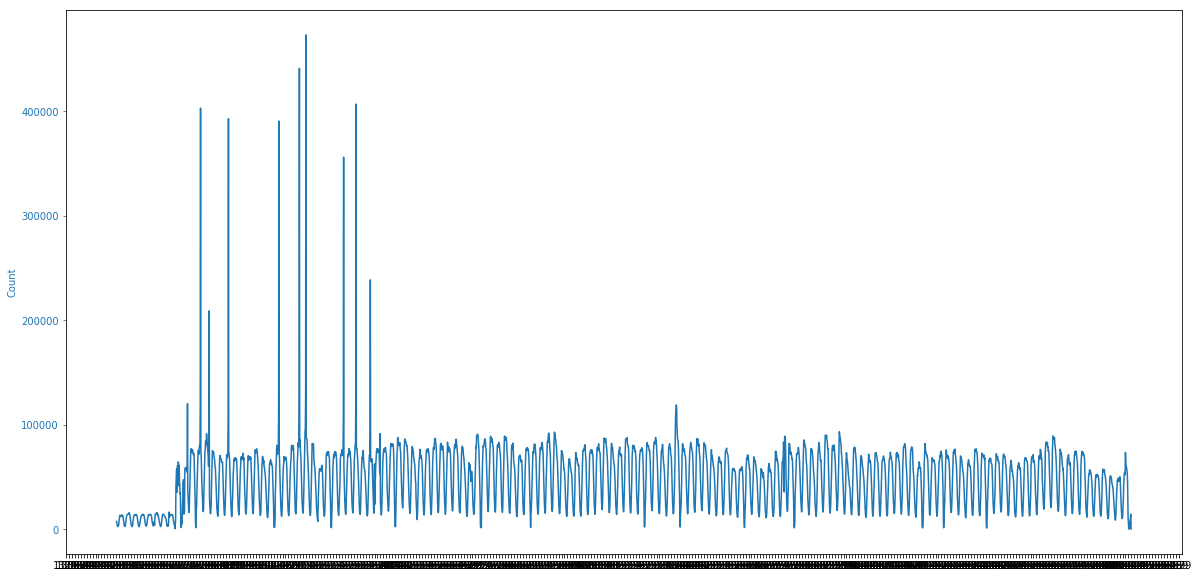

In [4]:
data2 = data[3000:].copy()
data2['ts'] = data2.val_ts%10000
fig, ax = plt.subplots(figsize=(20, 10), facecolor='w', edgecolor='C0')
ax.plot(data2.ts, data2.count_val, color='C0')
ax.set_ylabel('Count', color='C0')
ax.tick_params('y', colors='C0')
#plt.xticks(rotation=90)
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 10))
plt.show()

## Model Build - Isolation Forest

Detect anomaly score for data in a dataset.

Two anomaly score algorithms are run: one is IsolationForest, to detect the top 5 anomalous points. Then for each point another statistical based algorithm is applied to check if a point is above (below) a moving average plus standard deviation.

contamination: The assumed level of contamination in the data (percentage of anomaly score).
Returns list of (anomaly points, anomaly scores).

In [5]:
#contamination : float. The proportion of contaminated data in the training dataset. Can be an estimation, since the return value provides anomaly scores. Default is 0.01.
contamination=0.02
shingle_data = data2.count_val.values.reshape(-1, 1) #shingle(data.count_val)
model = IsolationForest(contamination=0.01) #, behaviour='new'

#Points with negative low score are considered anomalies.
model = model.fit(shingle_data)
sklearn_score_anomalies = model.decision_function(shingle_data)
original_paper_score = [-1 * s - .5 for s in sklearn_score_anomalies]
print(sklearn_score_anomalies[0:100])
#Using The Model to Assess Anomaly Score
#data_prep = shingle(['600', '5120', '5530', '5601', '550140', '570150', '550130', '520145', '490250', '570100', '560120', '550115']*3)
#data_prep = np.array(['600', '5120', '5530', '5601', '550140', '570150', '550130', '520145', '490250', '570100', '560120', '550115']*3).reshape(-1,1)
#For each observation, tells whether or not (+1 or -1) it should be considered as an inlier according to the fitted model.
#print(model.predict(data_prep))
#model.predict(shingle(['130000', '1800', '500330']*5))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


[-0.07042914 -0.07999552 -0.07757257 -0.08276754 -0.08506519 -0.08449493
 -0.08147172 -0.0791378  -0.08041183 -0.05854602 -0.01779915  0.0383571
  0.0383571   0.03302387  0.03203906  0.0122387   0.03692006  0.02484147
  0.03866205  0.02881909  0.03220767  0.03809292 -0.00550916 -0.05327841
 -0.07885829 -0.07866373 -0.07840474 -0.08147172 -0.08449493 -0.08173455
 -0.08132414 -0.08423186 -0.05613436 -0.01187823  0.02939776  0.0488359
  0.04560741  0.04644452  0.0425504   0.04038229  0.03971109  0.03910711
  0.03056402  0.03359464  0.04560741  0.0463434   0.00201866 -0.06335353
 -0.07514035 -0.07838827 -0.08260642 -0.08275581 -0.0840996  -0.08433509
 -0.07835465 -0.08115584 -0.05296197 -0.01518783  0.01295515  0.02461727
  0.04401065  0.04806126  0.0434314   0.03896086  0.04560741  0.049133
  0.04652587  0.04272152  0.03864882  0.0297329  -0.00399146 -0.06335353
 -0.0788002  -0.07921791 -0.07970109 -0.08147172 -0.0835721  -0.08154419
 -0.07838827 -0.0824655  -0.05906177 -0.02644985  0.002

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


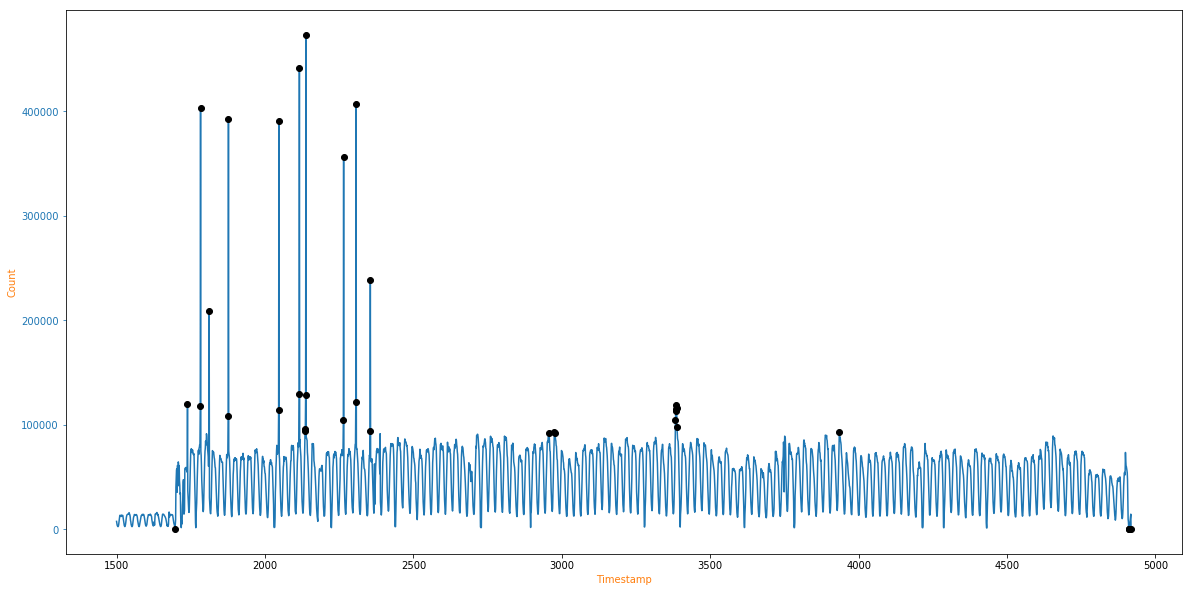

In [6]:
y_data = model.predict(data2.count_val.values.reshape(-1,1))
anom, = np.where(y_data == -1)
#fig, ax = plt.subplots(figsize=(20, 10), facecolor='w', edgecolor='C0')
figure(figsize=(20, 10), facecolor='w', edgecolor='C0')
plt.plot(data2.ts, data2.count_val, color='C0')
plt.plot(data2.ts.values[anom], data2.count_val.values[anom], 'ko')
plt.ylabel('Count', color='C1')
plt.xlabel('Timestamp', color='C1')
plt.tick_params('y', colors='C0')
#plt.xticks(rotation=90)
#start, end = ax.get_xlim()
#ax.xaxis.set_ticks(np.arange(start, end, 10))
plt.show()

In [7]:
data2.session_ts.values[anom]

array(['Mon, 01 Apr 2019 09', 'Wed, 03 Apr 2019 03',
       'Thu, 04 Apr 2019 22', 'Thu, 04 Apr 2019 23',
       'Sat, 06 Apr 2019 04', 'Mon, 08 Apr 2019 20',
       'Mon, 08 Apr 2019 21', 'Mon, 15 Apr 2019 22',
       'Mon, 15 Apr 2019 23', 'Thu, 18 Apr 2019 19',
       'Thu, 18 Apr 2019 20', 'Fri, 19 Apr 2019 15',
       'Fri, 19 Apr 2019 16', 'Fri, 19 Apr 2019 17',
       'Fri, 19 Apr 2019 18', 'Thu, 25 Apr 2019 00',
       'Thu, 25 Apr 2019 01', 'Fri, 26 Apr 2019 18',
       'Fri, 26 Apr 2019 19', 'Sun, 28 Apr 2019 18',
       'Sun, 28 Apr 2019 19', 'Thu, 23 May 2019 20',
       'Fri, 24 May 2019 15', 'Fri, 24 May 2019 16',
       'Mon, 10 Jun 2019 15', 'Mon, 10 Jun 2019 16',
       'Mon, 10 Jun 2019 17', 'Mon, 10 Jun 2019 18',
       'Mon, 10 Jun 2019 19', 'Mon, 10 Jun 2019 20',
       'Wed, 03 Jul 2019 15', 'Tue, 13 Aug 2019 06',
       'Tue, 13 Aug 2019 07', 'Tue, 13 Aug 2019 08',
       'Tue, 13 Aug 2019 14'], dtype=object)

## Moving Average

In [8]:
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

data['MOV'] = movingaverage(data.count_val,10).tolist()
STD = 3 * np.std(data.MOV) #/1.1
events= []
data['anomaly_score'] = 0
data.loc[data.count_val > data.MOV+STD, 'anomaly_score'] = (data.count_val/(data.MOV+STD))
data.loc[data.count_val < data.MOV-STD, 'anomaly_score'] = (data.count_val/(data.MOV-STD))

#Anomalies are points with anomaly_score that is very high or very low.
print(data[['count_val', 'session_ts', 'anomaly_score']].loc[data.anomaly_score != 0])

      count_val           session_ts  anomaly_score
2700     327233  Mon, 11 Mar 2019 16       2.660546
2732     341988  Wed, 13 Mar 2019 00       2.718964
3283     402731  Thu, 04 Apr 2019 23       2.187037
3312     208824  Sat, 06 Apr 2019 04       1.488827
3377     392718  Mon, 08 Apr 2019 21       2.164052
3547     390455  Mon, 15 Apr 2019 23       2.186554
3616     440883  Thu, 18 Apr 2019 20       2.250932
3638     472831  Fri, 19 Apr 2019 18       2.330744
3765     355847  Thu, 25 Apr 2019 01       2.134886
3807     406721  Fri, 26 Apr 2019 19       2.148242
3855     238501  Sun, 28 Apr 2019 19       1.485031


## Exercies: Searching For Anomalies on Contact Support

In [9]:
url_string = f"dbname='prod' port=5439 user='{USER}' password='{PASSWORD}' host='{HOST}'"
con = psycopg2.connect(url_string)
print(time.ctime(), "Redshift connection Successful!")
cur = con.cursor()

#In this query we need to configure the number of days to look back for anomalies.
sqlmsg = "with ts as (select max(session_ts) - 14 * 24 * 3600000 as session_ts from page_loads_tf) \
          select session_ts/3600000 as val_ts, count(distinct session_uuid) as count_val \
          from page_loads_tf \
          where session_ts > (select * from ts) and uri like '%https://www.simplemobile.com/contactus%' \
          group by session_ts/3600000 \
          order by val_ts asc;"
cur.execute(sqlmsg)
data = pd.DataFrame(cur.fetchall(), columns=['val_ts', 'count_val'])
data['date'] = data.val_ts.apply(lambda x: time.strftime('%Y-%m-%d %H', time.localtime(x*3600)))
data.head()

Tue Aug 13 14:36:33 2019 Redshift connection Successful!


,val_ts,count_val,date
0,434582,42,2019-07-30 14
1,434583,44,2019-07-30 15
2,434584,51,2019-07-30 16
3,434585,48,2019-07-30 17
4,434586,77,2019-07-30 18


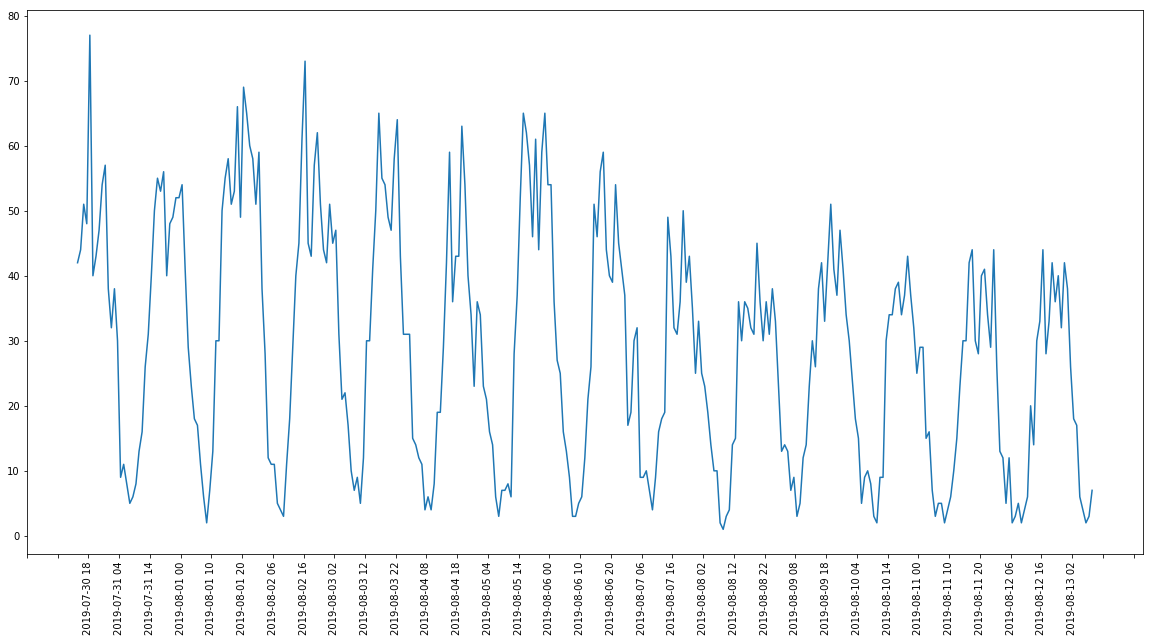

In [10]:
fig, ax = plt.subplots(figsize=(20, 10), facecolor='w', edgecolor='k')
ax.plot(data.date, data.count_val)
plt.xticks(rotation=90)
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 10))
plt.show()